In [ ]:
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# ​​ Load hourly S&P 500 data via SPY ETF as proxy
ticker = "SPY"  # Represents S&P 500
df1h = yf.download(ticker, period="600d", interval="4h", auto_adjust=True)
df1h.dropna(inplace=True)

df = df1h.xs('SPY', level=1, axis=1)
# ​​ Aggregate hourly data into 4-hour bars
#    Choose an offset that aligns with market open (e.g., 9:30 EST)
offset = datetime.timedelta(hours=0)  # Adjust if needed
ohlc = {
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}
df.head()



[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Datetime,,,,,
2023-03-29 13:30:00+00:00,400.375000,400.450012,398.679993,399.924988,37857792
2023-03-29 17:30:00+00:00,401.350006,401.600006,399.230011,400.370087,31520455
2023-03-30 13:30:00+00:00,402.445007,404.350006,402.059998,404.089996,38530485
2023-03-30 17:30:00+00:00,403.690002,403.779999,401.760010,402.440002,24395011
2023-03-31 13:30:00+00:00,407.000000,407.690002,404.549988,404.660004,42471749


In [ ]:
! pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 5.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

In [ ]:
df4h = df

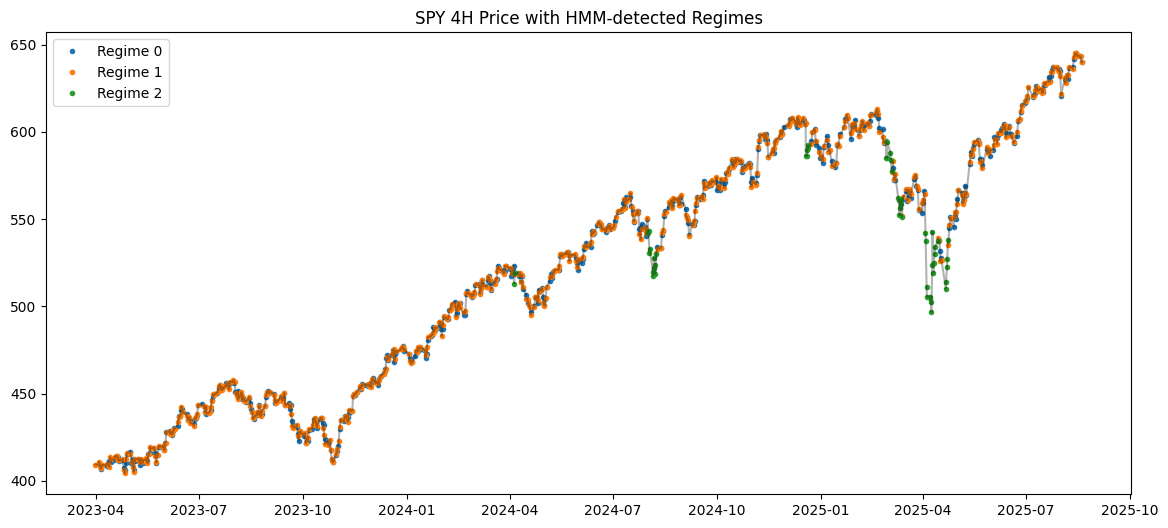

In [ ]:
# 2. Compute features: log returns + volatility proxy
df4h['log_ret'] = np.log(df4h['Close']).diff()
df4h['vol'] = df4h['log_ret'].rolling(5).std()  # short-term vol

features = df4h[['log_ret', 'vol']].dropna()

# 3. Fit HMM (3 regimes)
model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000, random_state=42)
model.fit(features)

# 4. Predict hidden states (regimes)
hidden_states = model.predict(features)

df4h = df4h.loc[features.index].copy()
df4h['Regime'] = hidden_states

# 5. Plot regimes
plt.figure(figsize=(14,6))
for state in np.unique(hidden_states):
    mask = df4h['Regime'] == state
    plt.plot(df4h.index[mask], df4h['Close'][mask],
             '.', label=f"Regime {state}", markersize=6)
plt.plot(df4h.index, df4h['Close'], 'k-', alpha=0.3)
plt.legend()
plt.title("SPY 4H Price with HMM-detected Regimes")
plt.show()

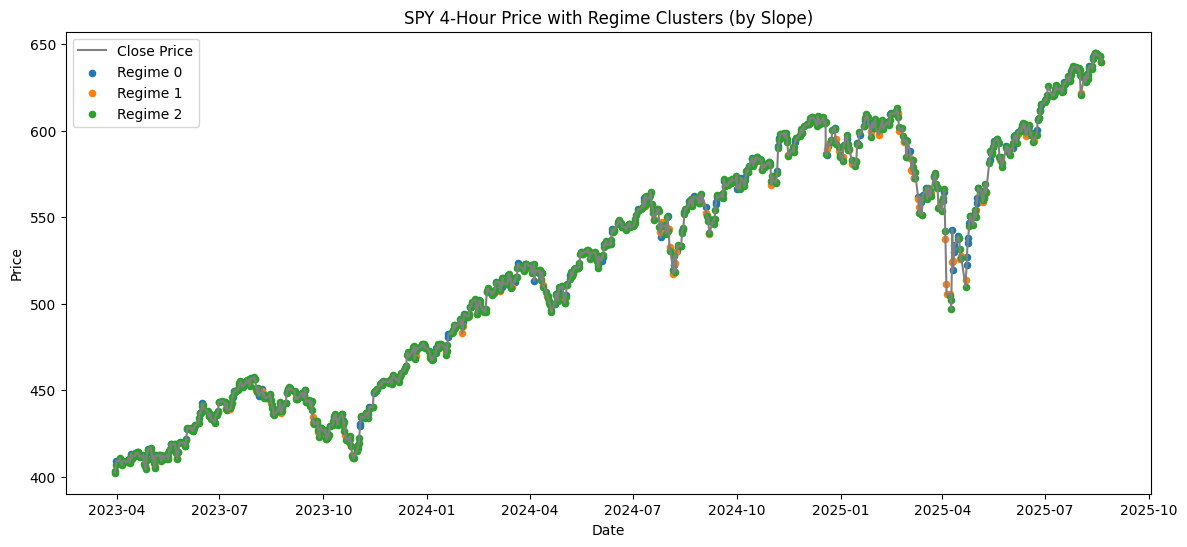

In [ ]:
df4h = df
# ​​ Compute rolling slope (trend) over a rolling window of N bars (e.g., 20)
window = 2
timestamps = np.arange(window).reshape(-1, 1)

slopes = []
for i in range(window, len(df4h)):
    y = df4h['Close'].values[i-window:i]
    X = timestamps
    reg = LinearRegression().fit(X, y)
    slopes.append(reg.coef_[0])

df4h = df4h.iloc[window:].copy()
df4h['slope'] = slopes

# ​​ Cluster slopes into regimes (e.g., 3 regimes)
num_clusters = 3
X = df4h[['slope']].values
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(X)
df4h['regime'] = kmeans.labels_
# df4h = df4h.iloc[-400:]
# ​​ Visualize regimes on price chart
plt.figure(figsize=(14, 6))
plt.plot(df4h.index, df4h['Close'], color='gray', label='Close Price')
for regime in sorted(df4h['regime'].unique()):
    mask = df4h['regime'] == regime
    plt.scatter(df4h.index[mask], df4h['Close'][mask],
                label=f"Regime {regime}", s=20)
plt.legend()
plt.title("SPY 4-Hour Price with Regime Clusters (by Slope)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

<Axes: xlabel='Datetime'>

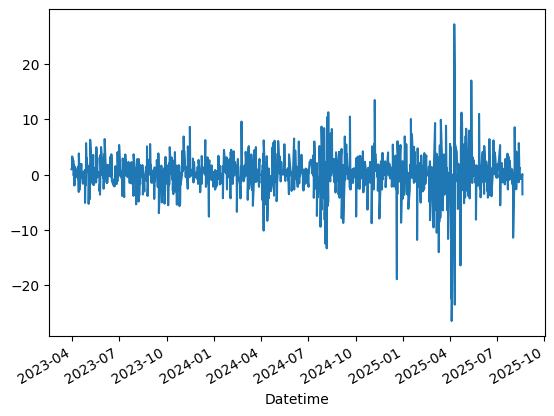

In [ ]:
df4h['slope'].plot()

#### SELECT HERE

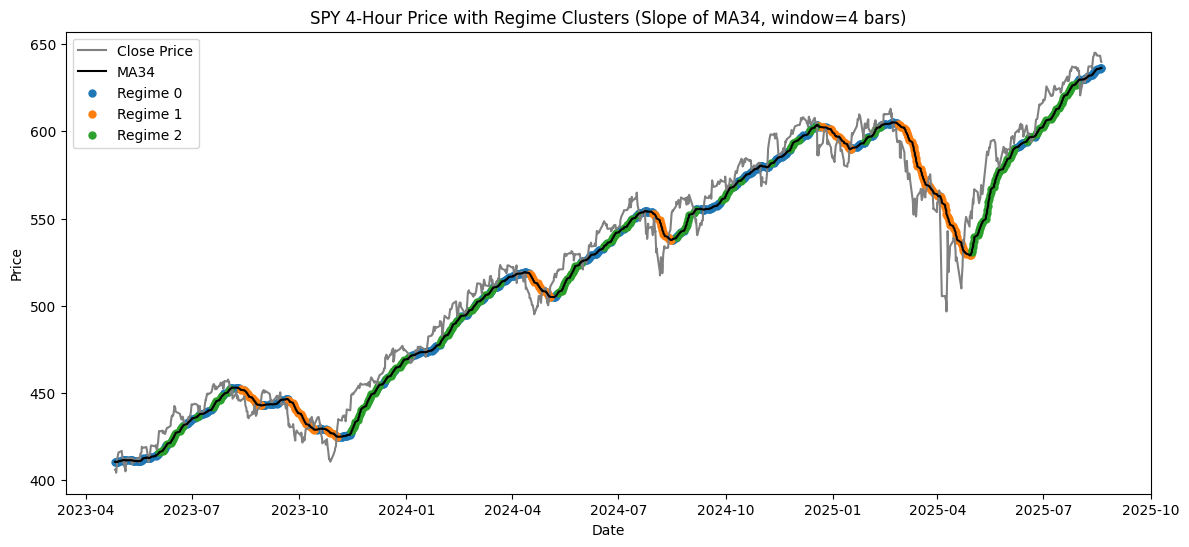

In [ ]:
## Select the one
window = 2  # 4 bars = 16 hours
df4h['MA34'] = df4h['Close'].rolling(34).mean()
df4h = df4h.dropna()
timestamps = np.arange(window).reshape(-1, 1)

slopes = []
for i in range(window, len(df4h)):
    y = df4h['MA34'].values[i-window:i]
    X = timestamps
    reg = LinearRegression().fit(X, y)
    slopes.append(reg.coef_[0])

df4h = df4h.iloc[window:].copy()
df4h['slope'] = slopes

# 4. Cluster slopes into regimes (3 clusters)
num_clusters = 3
X = df4h[['slope']].values
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(X)
df4h['regime'] = kmeans.labels_

# 5. Plot with regimes
plt.figure(figsize=(14, 6))
plt.plot(df4h.index, df4h['Close'], color='gray', label='Close Price')
plt.plot(df4h.index, df4h['MA34'], color='black', label='MA34')

for regime in sorted(df4h['regime'].unique()):
    mask = df4h['regime'] == regime
    plt.scatter(df4h.index[mask], df4h['MA34'][mask],
                label=f"Regime {regime}", s=25)

plt.legend()
plt.title("SPY 4-Hour Price with Regime Clusters (Slope of MA34, window=4 bars)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

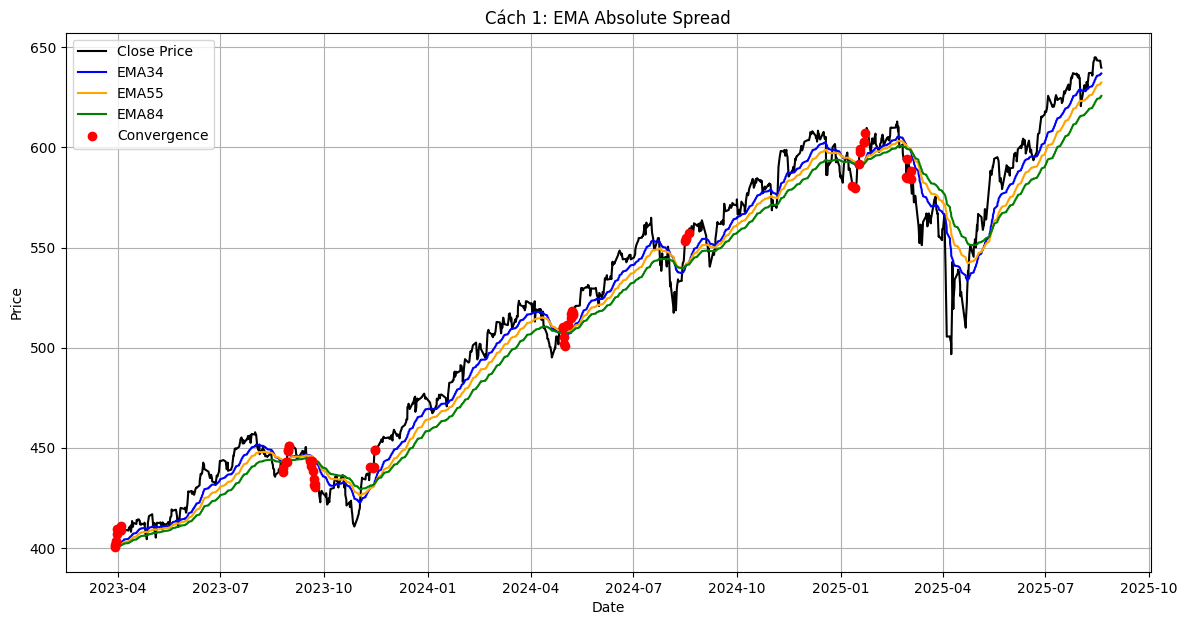

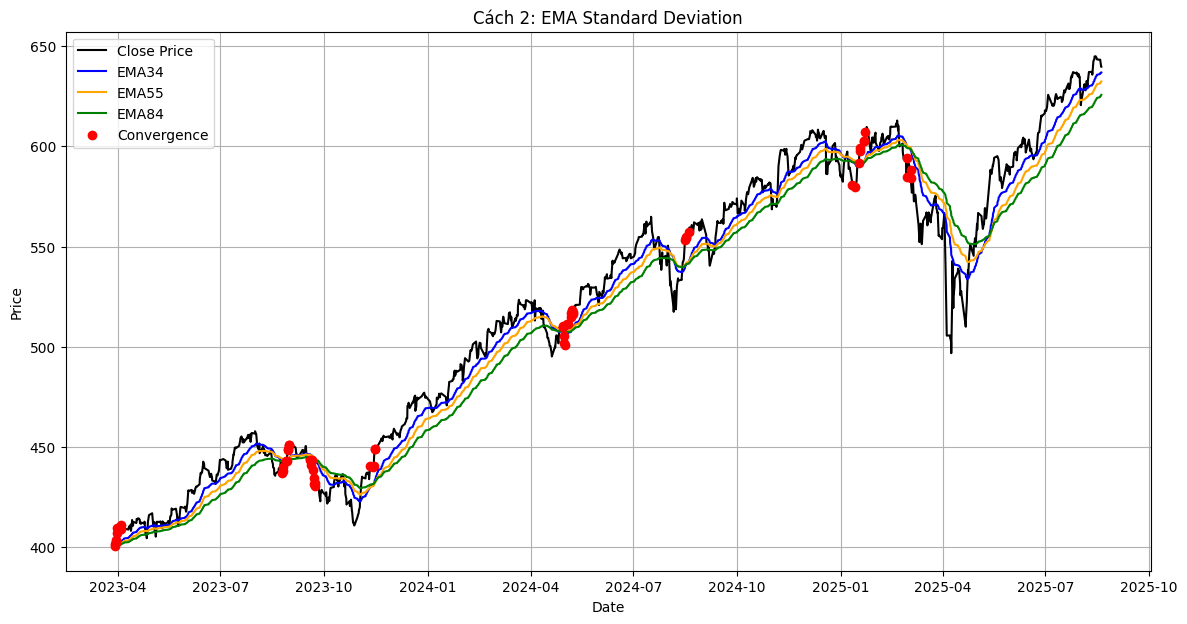

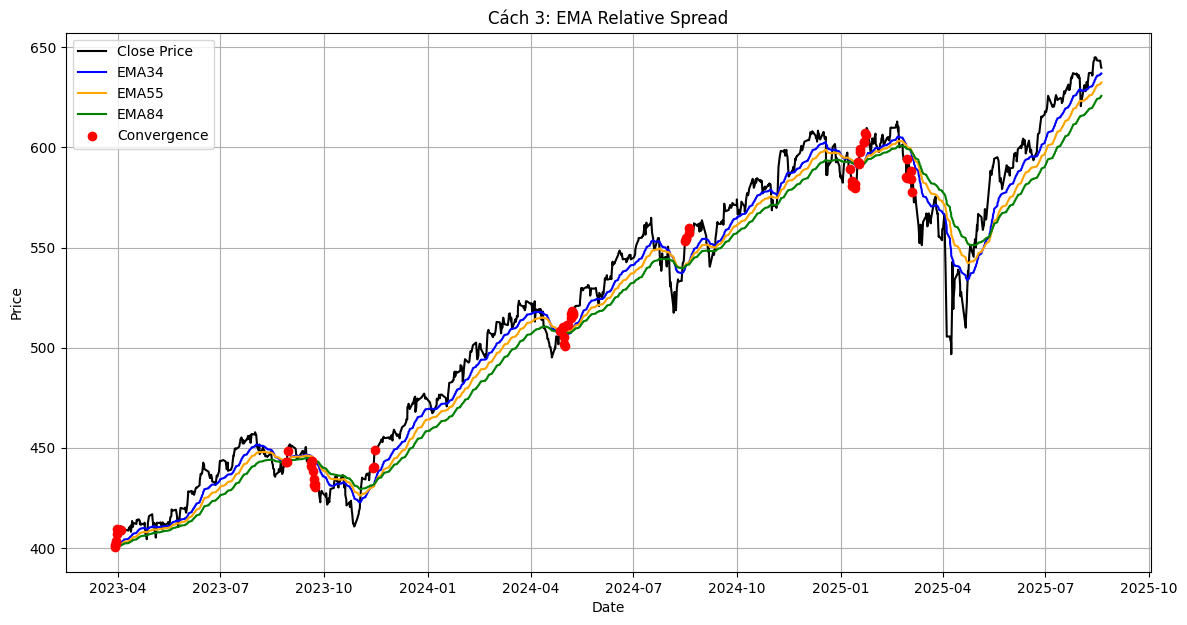

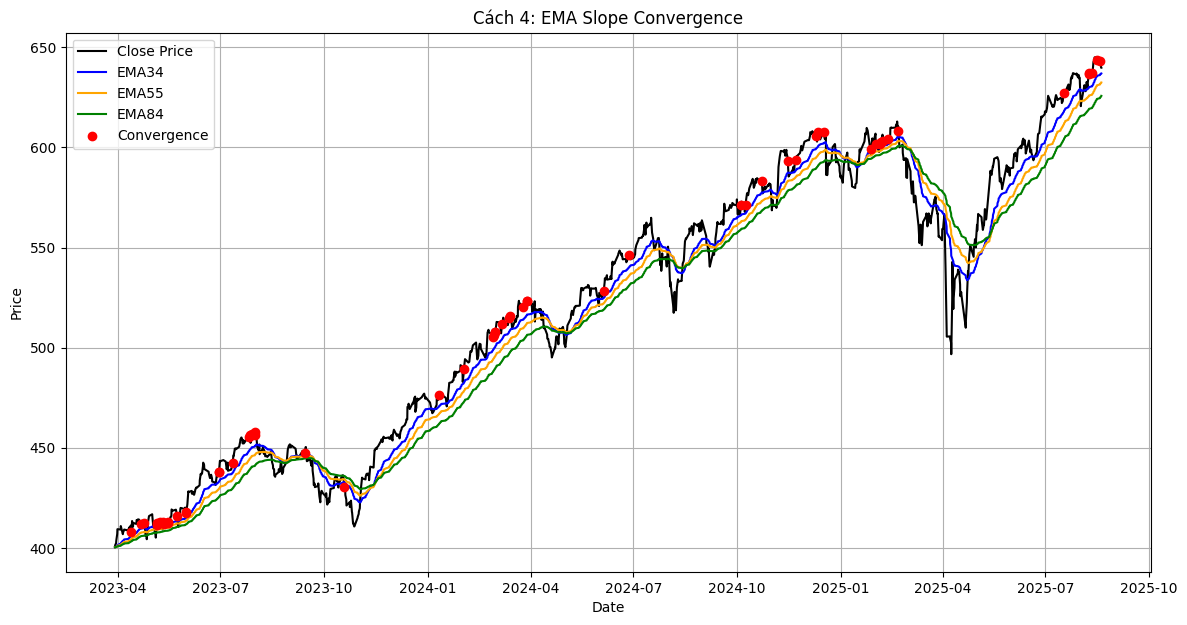

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Giả sử df đã có sẵn 'Close'
# Tính EMA
df['EMA34'] = df['Close'].ewm(span=34, adjust=False).mean()
df['EMA55'] = df['Close'].ewm(span=55, adjust=False).mean()
df['EMA84'] = df['Close'].ewm(span=84, adjust=False).mean()

# -----------------------
# Cách 1: Spread tuyệt đối
# -----------------------
df['diff_34_55'] = (df['EMA34'] - df['EMA55']).abs()
df['diff_34_84'] = (df['EMA34'] - df['EMA84']).abs()
df['diff_55_84'] = (df['EMA55'] - df['EMA84']).abs()
df['ema_spread'] = df['diff_34_55'] + df['diff_34_84'] + df['diff_55_84']
th1 = df['ema_spread'].quantile(0.05)
df['converge1'] = df['ema_spread'] < th1

# -----------------------
# Cách 2: Độ lệch chuẩn (std)
# -----------------------
df['ema_std'] = df[['EMA34','EMA55','EMA84']].std(axis=1)
th2 = df['ema_std'].quantile(0.05)
df['converge2'] = df['ema_std'] < th2

# -----------------------
# Cách 3: Spread tương đối
# -----------------------
df['ema_mean'] = df[['EMA34','EMA55','EMA84']].mean(axis=1)
df['ema_rel_spread'] = df['ema_spread'] / df['ema_mean']
th3 = df['ema_rel_spread'].quantile(0.05)
df['converge3'] = df['ema_rel_spread'] < th3

# -----------------------
# Cách 4: Slope convergence
# -----------------------
df['slope34'] = df['EMA34'].diff()
df['slope55'] = df['EMA55'].diff()
df['slope84'] = df['EMA84'].diff()
df['slope_spread'] = (df['slope34'] - df['slope55']).abs() + \
                     (df['slope34'] - df['slope84']).abs() + \
                     (df['slope55'] - df['slope84']).abs()
th4 = df['slope_spread'].quantile(0.05)
df['converge4'] = df['slope_spread'] < th4

# -----------------------
# Hàm vẽ chart
# -----------------------
def plot_convergence(df, col, title):
    plt.figure(figsize=(14,7))
    plt.plot(df.index, df['Close'], label='Close Price', color='black')
    plt.plot(df.index, df['EMA34'], label='EMA34', color='blue')
    plt.plot(df.index, df['EMA55'], label='EMA55', color='orange')
    plt.plot(df.index, df['EMA84'], label='EMA84', color='green')

    plt.scatter(df.index[df[col]], df['Close'][df[col]],
                color='red', label='Convergence', zorder=5)

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Vẽ chart cho từng cách
plot_convergence(df, 'converge1', "Cách 1: EMA Absolute Spread")
plot_convergence(df, 'converge2', "Cách 2: EMA Standard Deviation")
plot_convergence(df, 'converge3', "Cách 3: EMA Relative Spread")
plot_convergence(df, 'converge4', "Cách 4: EMA Slope Convergence")


In [ ]:
## Convert to image:
from pyts.image import GramianAngularField

# Take Close prices (or log returns)
X = df4h['Close'].values.reshape(1, -1)

# Encode into GAF image
gaf = GramianAngularField(image_size=100, method='summation')
X_gaf = gaf.fit_transform(X)

plt.imshow(X_gaf[0], cmap='rainbow', origin='lower')
plt.title("Gramian Angular Field (SPY)")
plt.show()


ModuleNotFoundError: No module named 'pyts'

In [ ]:
from pyts.image import RecurrencePlot

rp = RecurrencePlot(threshold='point', percentage=20)
X_rp = rp.fit_transform(X)

plt.imshow(X_rp[0], cmap='binary', origin='lower')
plt.title("Recurrence Plot (SPY)")
plt.show()


In [ ]:
window_size = 100
X_windows = []
for i in range(len(df4h) - window_size):
    window = df4h['Close'].values[i:i+window_size].reshape(1, -1)
    X_windows.append(gaf.fit_transform(window)[0])  # GAF image


In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

X_flat = [img.flatten() for img in X_windows]
X_pca = PCA(n_components=20).fit_transform(X_flat)

kmeans = KMeans(n_clusters=3, random_state=42).fit(X_pca)
regimes = kmeans.labels_
df4h = df4h.iloc[window_size:].copy()
df4h['Regime'] = regimes

In [ ]:
# ---- 6. Visualize regimes on price ----
plt.figure(figsize=(14,6))
for state in np.unique(regimes):
    mask = df4h['Regime'] == state
    plt.plot(df4h.index[mask], df4h['Close'][mask],
             '.', label=f"Regime {state}", markersize=6)
plt.plot(df4h.index, df4h['Close'], 'k-', alpha=0.3)
plt.legend()
plt.title("SPY 4H Price with Image-based Clustered Regimes")
plt.show()

In [ ]:
### Colid spring using pattern

import pandas as pd
import mplfinance as mpf
import os

# Load OHLC data
data =  df4h#pd.read_csv('stock_data.csv', parse_dates=['Date'], index_col='Date')

# Create directory to save chart images
os.makedirs('charts', exist_ok=True)

window = 50  # number of candles per chart
for i in range(len(data) - window):
    window_data = data.iloc[i:i+window]
    filename = f'charts/chart_{i}.png'
    mpf.plot(window_data, type='candle', style='charles',
             savefig=filename, show_nontrading=False)
